In [55]:
#install numpy, pandas, matplolib, tensorflow, sklearn, pandas_datareader, seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from time import sleep
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

import seaborn as sns
import pandas_datareader as pd_dr

In [56]:
#Données d'entrainement doivent être différentes des données de test donc on s'arrete en 2019...
training_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2015,1,1), dt.datetime(2020,12,30) )
testing_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2021,1,1), dt.datetime.now() )
#Drop la adj Close

In [57]:
trend_training_data = training_data.copy()
trend_testing_data = testing_data.copy()

In [58]:
#trend preprocessing
trend_training_data_j1 = trend_training_data.shift(periods=1)
trend_testing_data_j1 = trend_testing_data.shift(periods=1)

#creation de la colonne tendance, dans laquelle on soustrait le prix du jour actuel au prix j-1
trend_training_data['Diff_J+1'] = trend_training_data["Close"] / trend_training_data_j1["Close"]
trend_testing_data['Diff_J+1'] = trend_testing_data["Close"] / trend_testing_data_j1["Close"]

#dans la colonne tendance, on remplace toutes les tendance de prix par True si elles augmentent et par False si elle diminue
#trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] >= 0] = True
#trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] < 0] = False

#trend_testing_data["Diff_J+1"].loc[trend_testing_data["Diff_J+1"] >= 0] = True
#trend_testing_data["Diff_J+1"].loc[trend_testing_data["Diff_J+1"] < 0] = False

#suppression des lignes avec NaN (la premiere n'a pas de tendance vu qu'on a pas de jour precedent
#on supprime la ligne plutot que de mettre une donnée fausse car il y'a 2192 lignes)
trend_training_data.dropna(subset = ["Diff_J+1"], inplace=True)
trend_testing_data.dropna(subset = ["Diff_J+1"], inplace=True)
#trend_training_data["Diff_J+1"]= trend_training_data["Diff_J+1"].astype('bool')
#trend_testing_data["Diff_J+1"]= trend_testing_data["Diff_J+1"].astype('bool')

In [59]:
print( trend_training_data['Diff_J+1'].value_counts() )
print( trend_testing_data['Diff_J+1'].value_counts() )

1.002492    1
1.005467    1
0.973621    1
1.011921    1
0.968119    1
           ..
1.012751    1
0.997064    1
0.974878    1
1.066445    1
1.005574    1
Name: Diff_J+1, Length: 2191, dtype: int64
1.093726    1
1.036048    1
0.994550    1
1.026489    1
1.036588    1
           ..
1.023227    1
0.992152    1
1.113182    1
0.926311    1
0.990693    1
Name: Diff_J+1, Length: 441, dtype: int64


In [60]:
print( trend_training_data.shape )

trend_training_x = trend_training_data.drop(columns=['Diff_J+1'])
print( trend_training_x.shape )
trend_training_y = trend_training_data['Diff_J+1']
print( trend_training_y.shape )


trend_testing_x = trend_testing_data.drop(columns=['Diff_J+1'])
print( trend_testing_x.shape )
trend_testing_y = trend_testing_data['Diff_J+1']
print( trend_testing_y.shape )
print( trend_testing_y.head )

trend_scaler = MinMaxScaler( feature_range=(0,1) ) 
trend_training_x = trend_scaler.fit_transform(trend_training_x)
trend_testing_x = trend_scaler.fit_transform(trend_testing_x)

(2191, 7)
(2191, 6)
(2191,)
(441, 6)
(441,)
<bound method NDFrame.head of Date
2021-01-02    1.093726
2021-01-03    1.020380
2021-01-04    0.975288
2021-01-05    1.063197
2021-01-06    1.083311
                ...   
2022-03-14    1.048008
2022-03-15    0.991732
2022-03-16    1.045887
2022-03-17    0.995320
2022-03-18    0.990693
Name: Diff_J+1, Length: 441, dtype: float64>


In [61]:
#Random Forest Regressor Model 
model = RandomForestRegressor()
model.fit( trend_training_x, trend_training_y )

RandomForestRegressor()

R-squared: 0.93141260868731
MSE:  0.0009059447148560677
RMSE:  0.00045297235742803384


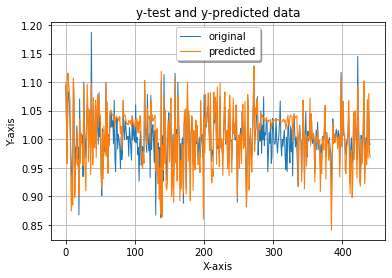

In [62]:
score = model.score( trend_training_x, trend_training_y )
print("R-squared:", score) 

trend_prediction = model.predict( trend_testing_x  )

mse = mean_squared_error( trend_testing_y, trend_prediction )
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 



x_ax = range(len(trend_testing_y))
plt.plot(x_ax, trend_testing_y, linewidth=1, label="original")
plt.plot(x_ax, trend_prediction, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 


In [64]:
lstm_training_data = training_data.copy()
lstm_testing_data = testing_data.copy()

lstm_training_data = lstm_training_data.iloc[1: , :]
lstm_training_data['Predicted Trend'] = trend_training_y
lstm_training_data = lstm_training_data.drop(['Adj Close'], axis='columns')


lstm_testing_data = lstm_testing_data.iloc[1: , :]
lstm_testing_data['Predicted Trend'] = trend_prediction
lstm_testing_data = lstm_testing_data.drop(['Adj Close'], axis='columns')

print( lstm_training_data.shape )
print( lstm_testing_data.shape )
print( lstm_training_data.head )
print( lstm_testing_data.head )

(2191, 6)
(441, 6)
<bound method NDFrame.head of                     High           Low          Open         Close  \
Date                                                                 
2015-01-02    315.838989    313.565002    314.079010    315.032013   
2015-01-03    315.149994    281.082001    314.846008    281.082001   
2015-01-04    287.230011    257.612000    281.145996    264.195007   
2015-01-05    278.341003    265.084015    265.084015    274.473999   
2015-01-06    287.553009    272.696014    274.610992    286.188995   
...                  ...           ...           ...           ...   
2020-12-27  28288.839844  25922.769531  26439.373047  26272.294922   
2020-12-28  27389.111328  26207.640625  26280.822266  27084.808594   
2020-12-29  27370.720703  25987.298828  27081.810547  27362.437500   
2020-12-30  28937.740234  27360.089844  27360.089844  28840.953125   
2020-12-31  29244.876953  28201.992188  28841.574219  29001.720703   

                 Volume  Predicted Trend

In [65]:
#LSTM Preprocessing

scaler = MinMaxScaler( feature_range=(0,1) )

scaled_data = scaler.fit_transform( lstm_training_data ) 

#Fragmente le dataset en plusieurs packets
chunks_size = 90

lstm_training_x, lstm_training_y = list(), list()

for x in range( chunks_size, len(scaled_data) ):
    lstm_training_x.append(scaled_data[x-chunks_size:x])
    lstm_training_y.append(scaled_data[x])
    
lstm_training_x, lstm_training_y = np.array(lstm_training_x), np.array(lstm_training_y)

In [66]:
#Neural network
model = Sequential()

model.add( LSTM(units=60, return_sequences=True, input_shape=(lstm_training_x.shape[1], 6)) )
model.add( Dropout(0.2) )
model.add( LSTM(units=80, return_sequences=True) )
model.add( Dropout(0.3) ) 
model.add( LSTM(units=120) )
model.add( Dropout(0.4) ) 
model.add( Dense(units=6) )

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(lstm_training_x, lstm_training_y , epochs=30, batch_size=32, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 60)            16080     
                                                                 
 dropout (Dropout)           (None, 90, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 90, 80)            45120     
                                                                 
 dropout_1 (Dropout)         (None, 90, 80)            0         
                                                                 
 lstm_2 (LSTM)               (None, 120)               96480     
                                                                 
 dropout_2 (Dropout)         (None, 120)               0         
                                                                 
 dense (Dense)               (None, 6)                 7

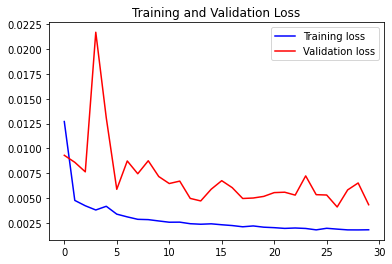

In [67]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

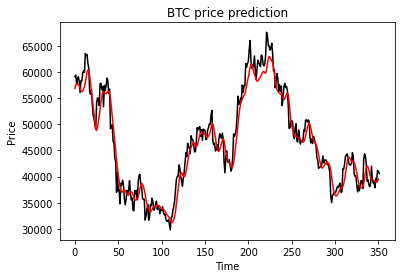

In [68]:
#Test du modèle
actual_prices = lstm_testing_data['Close'].values
actual_prices = actual_prices[89:x]

#actual_prices = actual_prices * scaler.scale_[3]

model_inputs = lstm_testing_data.values

model_inputs = scaler.fit_transform(model_inputs)

lstm_testing_x = list()
for x in range( chunks_size, len(model_inputs) ):
    lstm_testing_x.append( model_inputs[x-chunks_size:x] )
    
lstm_testing_x = np.array(lstm_testing_x)


prediction_prices = model.predict(lstm_testing_x)
prediction_prices = scaler.inverse_transform(prediction_prices)[:, [3]]

#prediction_prices.shape

plt.plot(actual_prices, color='black', label='actual_prices')
plt.plot(prediction_prices, color='red', label='predicted_prices')
plt.title('BTC price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()